In [8]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torchvision.transforms import transforms

from PIL import Image
from myutil import Logger, Parameters

In [2]:
class SpectrogramDataset(Dataset):
    """Spectrogram dataset."""

    def __init__(self, audio_files_df, max_height=200, max_width=1600):
        """
        Args:
            data_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.max_height = max_height
        self.max_width = max_width
        
        self.audio_files_df = audio_files_df
     
        
    def __len__(self):
        return self.audio_files_df.shape[0]

    def __getitem__(self, idx):
        row = audio_files_df.iloc[idx]
        padded = np.zeros((self.max_height, self.max_width))
        spectrogram = np.load(row['output_path'])
        padded[:spectrogram.shape[0], :spectrogram.shape[1]] = spectrogram[:self.max_height, :self.max_width]
        padded = torch.FloatTensor(padded)
        seq_len = min(spectrogram.shape[1], self.max_width)
        return padded, seq_len, row['label']

In [9]:
param_file = 'parameters.json'
csv_file = 'audio_files.csv'

params = Parameters(param_file)

# Read the csv with all the filenames and remove the one case 156 because only 3 samples
audio_files_df = pd.read_csv(csv_file, index_col=0)
audio_files_df = audio_files_df[audio_files_df['label'] != 156]

# Encode the label
label_encoder = LabelEncoder()
audio_files_df.loc[:, 'label'] = label_encoder.fit_transform(audio_files_df.loc[:, 'label'])

# Split into train and test
audio_files_train_df, audio_files_valid_df = train_test_split(audio_files_df, 
                                                              test_size=0.15,
                                                              stratify=audio_files_df['label'])

# Create datasets and dataloaders
spectrogram_dataset_train = SpectrogramDataset(audio_files_train_df, params.max_height, params.max_width)
spectrogram_dataset_valid = SpectrogramDataset(audio_files_valid_df, params.max_height, params.max_width)

spectrogram_dataloader_train = DataLoader(spectrogram_dataset_train, shuffle=True, batch_size=params.batch_size)
spectrogram_dataloader_valid = DataLoader(spectrogram_dataset_valid, shuffle=True, batch_size=params.batch_size)
dataloader_size_train = len(spectrogram_dataloader_train)
dataloader_size_valid = len(spectrogram_dataloader_valid)
assert audio_files_valid_df['label'].unique().shape[0] == audio_files_train_df['label'].unique().shape[0]
print(dataloader_size_train)
print(dataloader_size_valid)

2366
418


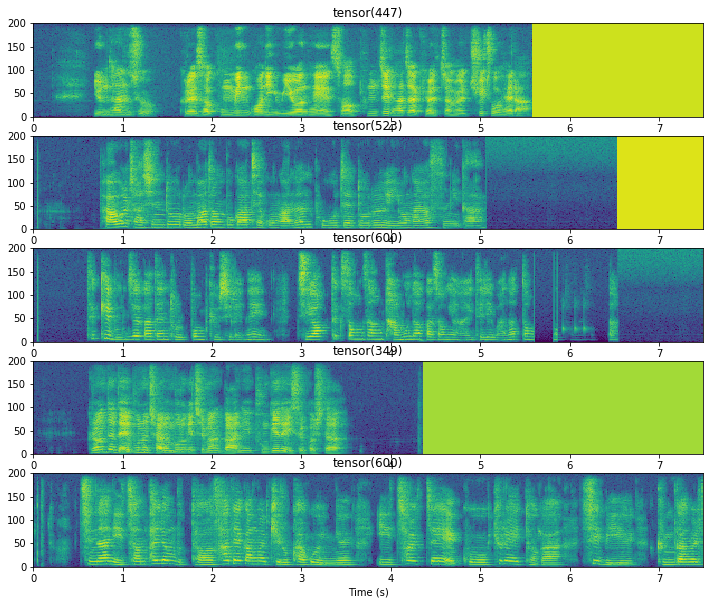

In [4]:
def show_spectrograms(spectrograms, seq_lengths, n_items=5):
    plt.figure(figsize=(12, 10))
    for i in range(n_items):
        plt.subplot(n_items, 1, i + 1)

        plt.title(seq_lengths[i])
        spectrogram = spectrograms[i].numpy()
        x, y = np.mgrid[:spectrogram.shape[1], :spectrogram.shape[0]]
        plt.pcolormesh(x * params.hop_length / params.sample_rate, y, spectrogram.transpose(1, 0))
        plt.xlabel('Time (s)')
    plt.show()

spectrograms, seq_lens, labels = next(iter(spectrogram_dataloader_train))
show_spectrograms(spectrograms, seq_lens, 5)

In [5]:
class ConvGRU(nn.Module):
    def __init__(self, 
                 input_size,
                 n_classes,
                 kernel_sizes=[9, 5, 5],
                 channels=[4, 8, 16], 
                 n_gru_layers=2,
                 gru_hidden_size=64,
                 max_pool_kernel_size=2):
        
        super(ConvGRU, self).__init__()
        
        self.input_size = input_size
        self.n_classes = n_classes
        self.kernel_sizes = kernel_sizes
        self.channels = channels
        self.n_gru_layers = n_gru_layers
        self.gru_hidden_size = gru_hidden_size
        self.max_pool_kernel_size= max_pool_kernel_size

        # Assert kernel_sizes matches size of channels (the length is the number of conv layers)
        assert len(kernel_sizes) == len(channels)
        
        self.n_conv = len(kernel_sizes)
        
        # Append the first conv layer, which has 1 input channel
        self.conv_layers = nn.Sequential()
        self.conv_layers.add_module('conv0',
            nn.Sequential(
                nn.Conv1d(in_channels=1,
                          out_channels=channels[0],
                          kernel_size=kernel_sizes[0],
                          padding=int(np.floor(kernel_sizes[0]/2))),
                nn.BatchNorm1d(channels[0]),
                nn.ReLU()
            )
        )
        
        # Now append the rest of the convolutional layers
        for i in range(1, self.n_conv):
            self.conv_layers.add_module('conv' + str(i),
                nn.Sequential(
                    nn.Conv1d(in_channels=channels[i - 1], 
                              out_channels=channels[i],
                              kernel_size=kernel_sizes[i],
                              padding=int(np.floor(kernel_sizes[i] / 2))),
                    nn.BatchNorm1d(channels[i]),
                    nn.ReLU()
                )
            )
        
        # Now, we need the GRU. Let's create one
        
        self.bidirectional_gru = torch.nn.GRU(
                                    input_size=channels[-1] * self.input_size,
                                    hidden_size=self.gru_hidden_size,
                                    num_layers=self.n_gru_layers,
                                    bidirectional=True,
                                    batch_first=True)
        
        # We now need a sigmoid layer to make classification!
        self.sigmoid_layer = nn.Sequential(
                nn.Linear(2 * self.gru_hidden_size, self.n_classes),
                nn.Sigmoid()
            )
        
    def forward(self, x, x_lens):
        # Reshape the batch, height, sequence to be batch, sequence, height
        batch = x.shape[0]
        sequence = x.shape[2]
        x = x.permute(0, 2, 1).contiguous()
        
        # View as batchxsequence, height
        x = x.view(-1, 1, self.input_size)
        
        # Apply 1d convs
        x = self.conv_layers(x)
        
        # Now, reshape to tbe batch x seqeuence x channels * height
        x = x.view(batch, sequence, -1)
        
        # Let's pack the padded sequence
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True)
        x, h_n = self.bidirectional_gru(x)
        
        # And now pad the packed sequence to get back to the padded sequence
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
            
        # Output is batch, sequence, n_directions * gru_hidden_size
        # We get the first and last elements;  the last element is the at index of corresponding seq_len
        x = torch.cat((x[:, 0, self.gru_hidden_size:], x[np.arange(batch), x_lens - 1, :self.gru_hidden_size]), 1)

        # Run sigmoid layer
        x = self.sigmoid_layer(x)

        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

convgru = ConvGRU(params.max_height, label_encoder.classes_.shape[0]).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(convgru.parameters())

run_name = 'random_just_ignore'
comment = 'First run'

logger = Logger(run_name, comment)
logger.get_run_command()

'tensorboard --logdir=C:\\Users\\Jonathan\\Documents\\development\\voice-test/runs/random_just_ignore/Nov-30-2018-00h17m48s/ --host=127.0.0.1'

In [7]:
for epoch in range(params.n_epochs):
    # Do train and validation
    for phase in ['train', 'valid']:
        if phase == 'train':
            spectrogram_dataloader = spectrogram_dataloader_train
        else:
            spectrogram_dataloader = spectrogram_dataloader_valid

        # Run through the datasets
        for spectrograms, seq_lens, labels in spectrogram_dataloader:
            # Zero out the grad
            optimizer.zero_grad()
            
            # Sort the spectrograms by length for this batch
            indices = np.argsort(seq_lens.numpy() * -1)
            spectrograms = Variable(spectrograms[indices].to(device), requires_grad=True)
            seq_lens = seq_lens[indices]
            labels = Variable(labels[indices].to(device))

            # Run the network
            output = convgru(spectrograms.to(device), seq_lens)
            
            # Compute the loss
            loss = loss_function(output, labels)
            
            if phase == 'train':
                # Compute gradient and update using optimizer
                loss.backward()
                optimizer.step()

                # Log (write to tensorboardX) the loss
                logger.log(loss, phase)
                logger.step()

        if epoch % 5 == 0:
            print(f'[Epoch {epoch} / {params.n_epochs}] {phase} loss: {loss:.4f}')

[Epoch 0 / 100] train loss: 3.8903
[Epoch 0 / 100] valid loss: 4.6309
[Epoch 5 / 100] train loss: 3.8100
[Epoch 5 / 100] valid loss: 4.0012
[Epoch 10 / 100] train loss: 3.6781
[Epoch 10 / 100] valid loss: 3.6936
[Epoch 15 / 100] train loss: 3.6614
[Epoch 15 / 100] valid loss: 3.6881
[Epoch 20 / 100] train loss: 3.6817
[Epoch 20 / 100] valid loss: 3.6653
[Epoch 25 / 100] train loss: 3.6823
[Epoch 25 / 100] valid loss: 3.6638
[Epoch 30 / 100] train loss: 3.6697
[Epoch 30 / 100] valid loss: 3.6613


KeyboardInterrupt: 